In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator, Options
from qiskit.test.reference_circuits import ReferenceCircuits
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp

# Initialize account.
service = QiskitRuntimeService()

# Set options, which can be overwritten at job level.
options = Options(optimization_level=3)

# Prepare inputs.
bell = ReferenceCircuits.bell()
psi = RealAmplitudes(num_qubits=2, reps=2)
H1 = SparsePauliOp.from_list([("II", 1), ("IZ", 2), ("XI", 3)])
theta = [0, 1, 1, 2, 3, 5]

with Session(service=service, backend="ibmq_qasm_simulator") as session:
    # Submit a request to the Sampler primitive within the session.
    sampler = Sampler(session=session, options=options)
    job = sampler.run(circuits=bell)
    print(f"Sampler results: {job.result()}")

    # Submit a request to the Estimator primitive within the session.
    estimator = Estimator(session=session, options=options)
    job = estimator.run(
        circuits=[psi], observables=[H1], parameter_values=[theta]
    )
    print(f"Estimator results: {job.result()}")
    # Close the session only if all jobs are finished and you don't need to run more in the session.
    session.close()

Sampler results: SamplerResult(quasi_dists=[{0: 0.50425, 3: 0.49575}], metadata=[{'shots': 4000}])
Estimator results: EstimatorResult(values=array([1.5655]), metadata=[{'variance': 8.94386875, 'shots': 4000}])


In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes

from qiskit_machine_learning.neural_networks import EstimatorQNN

num_qubits = 2
feature_map = ZZFeatureMap(feature_dimension=num_qubits)
ansatz = RealAmplitudes(num_qubits=num_qubits, reps=1)

qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters
)

qnn.forward(input_data=[1, 2], weights=[1, 2, 3, 4])

array([[0.10695899]])

In [3]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes

from qiskit_machine_learning.neural_networks import EstimatorQNN

num_qubits = 2
feature_map = ZZFeatureMap(feature_dimension=num_qubits)
ansatz = RealAmplitudes(num_qubits=num_qubits, reps=1)

qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters
)

qnn.forward(input_data=[1, 2], weights=[1, 2, 3, 4])

array([[0.10695899]])

In [4]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from qiskit_machine_learning.circuit.library import ZZFeatureMap
from qiskit.algorithms.optimizers import COBYLA
from qiskit.datasets import load_iris

feature_dim = 4
_, iris_data, target = load_iris().values()

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)

qnn = TwoLayerQNN(feature_dim, quantum_instance=QuantumInstance(BasicAer.get_backend('qasm_simulator')))

vqc = VQC(optimizer=COBYLA(), feature_map=feature_map, ansatz=qnn, training_dataset=iris_data, 
           multiclass=True, label_to_class={0: 'setosa', 1: 'versicolor', 2: 'virginica'})

vqc.train(iris_data, target)

test_data = iris_data[0:5]
print(vqc.predict(test_data))


Traceback (most recent call last):
  Cell In[4], line 5
    from qiskit_machine_learning.circuit.library import ZZFeatureMap
ImportError: cannot import name 'ZZFeatureMap' from 'qiskit_machine_learning.circuit.library' (/opt/conda/lib/python3.10/site-packages/qiskit_machine_learning/circuit/library/__init__.py)

Use %tb to get the full traceback.


In [5]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes

from qiskit_machine_learning.neural_networks import SamplerQNN

num_qubits = 2
feature_map = ZZFeatureMap(feature_dimension=num_qubits)
ansatz = RealAmplitudes(num_qubits=num_qubits, reps=1)

qc = QuantumCircuit(num_qubits)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)


def parity(x):
    return "{:b}".format(x).count("1") % 2


qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=2
)

qnn.forward(input_data=[1, 2], weights=[1, 2, 3, 4])

array([[0.55347949, 0.44652051]])

In [37]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA
from qiskit.datasets import load_iris

feature_dim = 4
_, iris_data, target = load_iris().values()

estimator_feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
estimator_ansatz = RealAmplitudes(num_qubits=feature_dim, reps=1)

estimator_qnn = TwoLayerQNN(feature_dim, quantum_instance=QuantumInstance(BasicAer.get_backend('qasm_simulator')))

estimator = VQC(optimizer=COBYLA(), feature_map=estimator_feature_map, ansatz=estimator_ansatz, 
                 quantum_instance=QuantumInstance(BasicAer.get_backend('ibmq_qasm_simulator')))
estimator_qnn = CircuitQNN(circuit=estimator_circuit, input_params=estimator_feature_map.parameters, 
                           weight_params=estimator_ansatz.parameters, quantum_instance=QuantumInstance(BasicAer.get_backend('qasm_simulator')))

estimator.fit(iris_data, target)

estimator_predictions = estimator.predict(iris_data)

sampler_feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
sampler_ansatz = RealAmplitudes(num_qubits=feature_dim, reps=1)

def parity(x):
    return "{:b}".format(x).count("1") % 2

sampler_qnn = CircuitQNN(circuit=sampler_feature_map + sampler_ansatz, input_params=sampler_feature_map.parameters, 
                         weight_params=sampler_ansatz.parameters, interpret=parity, output_shape=2, 
                         quantum_instance=QuantumInstance(BasicAer.get_backend('qasm_simulator')))

sampler_qnn.fit(iris_data, target)

sampler_predictions = sampler_qnn.predict(iris_data)




Traceback (most recent call last):
  Cell In[37], line 5
    from qiskit_machine_learning.circuit.library import ZZFeatureMap, RealAmplitudes
ImportError: cannot import name 'ZZFeatureMap' from 'qiskit_machine_learning.circuit.library' (/opt/conda/lib/python3.10/site-packages/qiskit_machine_learning/circuit/library/__init__.py)

Use %tb to get the full traceback.


In [1]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA
from qiskit.datasets import load_iris

feature_dim = 4
_, iris_data, target = load_iris().values()

estimator_feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
estimator_ansatz = RealAmplitudes(num_qubits=feature_dim, reps=1)

estimator_qnn = TwoLayerQNN(feature_dim, quantum_instance=QuantumInstance(BasicAer.get_backend('qasm_simulator')))

estimator = VQC(optimizer=COBYLA(), feature_map=estimator_feature_map, ansatz=estimator_ansatz, 
                 quantum_instance=QuantumInstance(BasicAer.get_backend('qasm_simulator')))
estimator_qnn = CircuitQNN(circuit=estimator_circuit, input_params=estimator_feature_map.parameters, 
                           weight_params=estimator_ansatz.parameters, quantum_instance=QuantumInstance(BasicAer.get_backend('qasm_simulator')))

estimator.fit(iris_data, target)

estimator_predictions = estimator.predict(iris_data)

sampler_feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
sampler_ansatz = RealAmplitudes(num_qubits=feature_dim, reps=1)

def parity(x):
    return "{:b}".format(x).count("1") % 2

sampler_qnn = CircuitQNN(circuit=sampler_feature_map + sampler_ansatz, input_params=sampler_feature_map.parameters, 
                         weight_params=sampler_ansatz.parameters, interpret=parity, output_shape=2, 
                         quantum_instance=QuantumInstance(BasicAer.get_backend('qasm_simulator')))

sampler_qnn.fit(iris_data, target)

sampler_predictions = sampler_qnn.predict(iris_data)


Traceback (most recent call last):
  Cell In[1], line 5
    from qiskit_machine_learning.circuit.library import ZZFeatureMap, RealAmplitudes
ImportError: cannot import name 'ZZFeatureMap' from 'qiskit_machine_learning.circuit.library' (/opt/conda/lib/python3.10/site-packages/qiskit_machine_learning/circuit/library/__init__.py)

Use %tb to get the full traceback.


In [7]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms.classifiers import VQC


from qiskit_machine_learning.neural_networks import EstimatorQNN

from qiskit_machine_learning.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA
from qiskit.datasets import load_iris

feature_dim = 4
_, iris_data, target = load_iris().values()

estimator_feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
estimator_ansatz = RealAmplitudes(num_qubits=feature_dim, reps=1)

estimator_qnn = TwoLayerQNN(feature_dim, quantum_instance=QuantumInstance(BasicAer.get_backend('qasm_simulator')))

estimator = VQC(optimizer=COBYLA(), feature_map=estimator_feature_map, ansatz=estimator_ansatz, 
                 quantum_instance=QuantumInstance(BasicAer.get_backend('qasm_simulator')))
estimator_qnn = CircuitQNN(circuit=estimator_circuit, input_params=estimator_feature_map.parameters, 
                           weight_params=estimator_ansatz.parameters, quantum_instance=QuantumInstance(BasicAer.get_backend('qasm_simulator')))

estimator.fit(iris_data, target)

estimator_predictions = estimator.predict(iris_data)

sampler_feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
sampler_ansatz = RealAmplitudes(num_qubits=feature_dim, reps=1)

def parity(x):
    return "{:b}".format(x).count("1") % 2

sampler_qnn = CircuitQNN(circuit=sampler_feature_map + sampler_ansatz, input_params=sampler_feature_map.parameters, 
                         weight_params=sampler_ansatz.parameters, interpret=parity, output_shape=2, 
                         quantum_instance=QuantumInstance(BasicAer.get_backend('qasm_simulator')))

sampler_qnn.fit(iris_data, target)

sampler_predictions = sampler_qnn.predict(iris_data)


Traceback (most recent call last):
  Cell In[7], line 8
    from qiskit_machine_learning.circuit.library import ZZFeatureMap, RealAmplitudes
ImportError: cannot import name 'ZZFeatureMap' from 'qiskit_machine_learning.circuit.library' (/opt/conda/lib/python3.10/site-packages/qiskit_machine_learning/circuit/library/__init__.py)

Use %tb to get the full traceback.


In [8]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms.classifiers import VQC


from qiskit_machine_learning.neural_networks import EstimatorQNN

from qiskit.algorithms.optimizers import COBYLA
from qiskit.datasets import load_iris

feature_dim = 4
_, iris_data, target = load_iris().values()

estimator_feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
estimator_ansatz = RealAmplitudes(num_qubits=feature_dim, reps=1)

estimator_qnn = TwoLayerQNN(feature_dim, quantum_instance=QuantumInstance(BasicAer.get_backend('qasm_simulator')))

estimator = VQC(optimizer=COBYLA(), feature_map=estimator_feature_map, ansatz=estimator_ansatz, 
                 quantum_instance=QuantumInstance(BasicAer.get_backend('qasm_simulator')))
estimator_qnn = CircuitQNN(circuit=estimator_circuit, input_params=estimator_feature_map.parameters, 
                           weight_params=estimator_ansatz.parameters, quantum_instance=QuantumInstance(BasicAer.get_backend('qasm_simulator')))

estimator.fit(iris_data, target)

estimator_predictions = estimator.predict(iris_data)

sampler_feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
sampler_ansatz = RealAmplitudes(num_qubits=feature_dim, reps=1)

def parity(x):
    return "{:b}".format(x).count("1") % 2

sampler_qnn = CircuitQNN(circuit=sampler_feature_map + sampler_ansatz, input_params=sampler_feature_map.parameters, 
                         weight_params=sampler_ansatz.parameters, interpret=parity, output_shape=2, 
                         quantum_instance=QuantumInstance(BasicAer.get_backend('qasm_simulator')))

sampler_qnn.fit(iris_data, target)

sampler_predictions = sampler_qnn.predict(iris_data)


Traceback (most recent call last):
  Cell In[8], line 9
    from qiskit.datasets import load_iris
ModuleNotFoundError: No module named 'qiskit.datasets'

Use %tb to get the full traceback.


In [44]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA
from qiskit.datasets import load_iris


# Load the iris dataset
feature_dim = 4
_, iris_data, target = load_iris().values()

# Define the feature map and ansatz for the EstimatorQNN
estimator_feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
estimator_ansatz = RealAmplitudes(num_qubits=feature_dim, reps=1)

# Define the quantum neural network for the EstimatorQNN
estimator_qnn = TwoLayerQNN(feature_dim, quantum_instance=QuantumInstance(BasicAer.get_backend('qasm_simulator')))

# Define the EstimatorQNN
estimator_circuit = estimator_feature_map + estimator_ansatz
estimator = VQC(optimizer=COBYLA(), feature_map=estimator_feature_map, ansatz=estimator_ansatz, 
                 quantum_instance=QuantumInstance(BasicAer.get_backend('ibmq_qasm_simulator')))
estimator_qnn = CircuitQNN(circuit=estimator_circuit, input_params=estimator_feature_map.parameters, 
                           weight_params=estimator_ansatz.parameters, quantum_instance=QuantumInstance(BasicAer.get_backend('qasm_simulator')))

# Train the EstimatorQNN
estimator.fit(iris_data, target)

# Use the trained EstimatorQNN to make predictions
estimator_predictions = estimator.predict(iris_data)

# Define the feature map and ansatz for the SamplerQNN
sampler_feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
sampler_ansatz = RealAmplitudes(num_qubits=feature_dim, reps=1)

# Define the quantum neural network for the SamplerQNN
def parity(x):
    return "{:b}".format(x).count("1") % 2

sampler_qnn = CircuitQNN(circuit=sampler_feature_map + sampler_ansatz, input_params=sampler_feature_map.parameters, 
                         weight_params=sampler_ansatz.parameters, interpret=parity, output_shape=2, 
                         quantum_instance=QuantumInstance(BasicAer.get_backend('ibmq_qasm_simulator')))

# Train the SamplerQNN
sampler_qnn.fit(iris_data, target)

# Use the trained SamplerQNN to make predictions
sampler_predictions = sampler_qnn.predict(iris_data)


Traceback (most recent call last):
  Cell In[44], line 7
    from qiskit.datasets import load_iris
ModuleNotFoundError: No module named 'qiskit.datasets'

Use %tb to get the full traceback.


In [42]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA
from sklearn.datasets import load_iris


# Load the iris dataset
_, iris_data, target = load_iris(return_X_y=True)

# Define the feature map and ansatz for the EstimatorQNN
feature_dim = iris_data.shape[1]
estimator_feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
estimator_ansatz = RealAmplitudes(num_qubits=feature_dim, reps=1)

# Define the EstimatorQNN
estimator_circuit = estimator_feature_map + estimator_ansatz
estimator = VQC(optimizer=COBYLA(), feature_map=estimator_feature_map, ansatz=estimator_ansatz, 
                 quantum_instance=QuantumInstance(BasicAer.get_backend('ibmq_qasm_simulatorr')))
estimator_qnn = CircuitQNN(circuit=estimator_circuit, input_params=estimator_feature_map.parameters, 
                           weight_params=estimator_ansatz.parameters, quantum_instance=QuantumInstance(BasicAer.get_backend('qasm_simulator')))

# Train the EstimatorQNN
estimator.fit(iris_data, target)

# Use the trained EstimatorQNN to make predictions
estimator_predictions = estimator.predict(iris_data)

# Define the feature map and ansatz for the SamplerQNN
sampler_feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
sampler_ansatz = RealAmplitudes(num_qubits=feature_dim, reps=1)

# Define the quantum neural network for the SamplerQNN
def parity(x):
    return "{:b}".format(x).count("1") % 2

sampler_qnn = CircuitQNN(circuit=sampler_feature_map + sampler_ansatz, input_params=sampler_feature_map.parameters, 
                         weight_params=sampler_ansatz.parameters, interpret=parity, output_shape=2, 
                         quantum_instance=QuantumInstance(BasicAer.get_backend('qasm_simulator')))

# Train the SamplerQNN
sampler_qnn.fit(iris_data, target)

# Use the trained SamplerQNN to make predictions
sampler_predictions = sampler_qnn.predict(iris_data)



Traceback (most recent call last):
  Cell In[42], line 11
    _, iris_data, target = load_iris(return_X_y=True)
ValueError: not enough values to unpack (expected 3, got 2)

Use %tb to get the full traceback.


In [41]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.algorithms.classifiers.vqc import VQC
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA
from sklearn.datasets import load_iris


# Load the iris dataset
_, iris_data, target = load_iris(return_X_y=True)

# Define the feature map and ansatz for the EstimatorQNN
feature_dim = iris_data.shape[1]
estimator_feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
estimator_ansatz = RealAmplitudes(num_qubits=feature_dim, reps=1)

# Define the EstimatorQNN
estimator_circuit = estimator_feature_map + estimator_ansatz
estimator = VQC(optimizer=COBYLA(), feature_map=estimator_feature_map, ansatz=estimator_ansatz, 
                 quantum_instance=QuantumInstance(BasicAer.get_backend('ibmq_qasm_simulator')))
estimator_qnn = CircuitQNN(circuit=estimator_circuit, input_params=estimator_feature_map.parameters, 
                           weight_params=estimator_ansatz.parameters, quantum_instance=QuantumInstance(BasicAer.get_backend('qasm_simulator')))

# Train the EstimatorQNN
estimator.fit(iris_data, target)

# Use the trained EstimatorQNN to make predictions
estimator_predictions = estimator.predict(iris_data)

# Define the feature map and ansatz for the SamplerQNN
sampler_feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
sampler_ansatz = RealAmplitudes(num_qubits=feature_dim, reps=1)

# Define the quantum neural network for the SamplerQNN
def parity(x):
    return "{:b}".format(x).count("1") % 2

sampler_qnn = CircuitQNN(circuit=sampler_feature_map + sampler_ansatz, input_params=sampler_feature_map.parameters, 
                         weight_params=sampler_ansatz.parameters, interpret=parity, output_shape=2, 
                         quantum_instance=QuantumInstance(BasicAer.get_backend('qasm_simulator')))

# Train the SamplerQNN
sampler_qnn.fit(iris_data, target)

# Use the trained SamplerQNN to make predictions
sampler_predictions = sampler_qnn.predict(iris_data)



Traceback (most recent call last):
  Cell In[41], line 11
    _, iris_data, target = load_iris(return_X_y=True)
ValueError: not enough values to unpack (expected 3, got 2)

Use %tb to get the full traceback.


In [14]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")

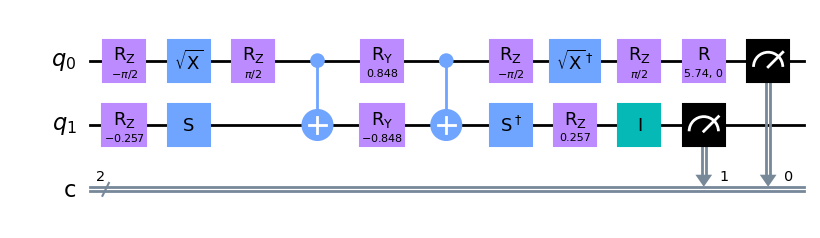

In [15]:
from qiskit.circuit.random import random_circuit

circuit = random_circuit(2, 2, seed=0, measure=True).decompose(reps=1)
display(circuit.draw("mpl"))

In [16]:
from qiskit_ibm_runtime import Session, Estimator

with Session(backend=backend, max_time="1h"):
    sampler = Sampler()

    result = sampler.run(circuit).result()
    print(f">>> Quasi-distribution from the first run: {result.quasi_dists[0]}")

    result = sampler.run(circuit).result()
    print(f">>> Quasi-distribution from the second run: {result.quasi_dists[0]}")

>>> Quasi-distribution from the first run: {1: 0.03175, 3: 0.515, 2: 0.03875, 0: 0.4145}
>>> Quasi-distribution from the second run: {1: 0.033, 2: 0.03375, 0: 0.39875, 3: 0.5345}


In [40]:
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Session,
    Sampler,
    Estimator,
    Options,
)

# 1. Initialize account
service = QiskitRuntimeService(channel="ibm_quantum")

# 2. Specify options, such as enabling error mitigation
options = Options(resilience_level=1)

# 3. Select a backend.
backend = service.backend("ibmq_qasm_simulator")

# 4. Create a session
with Session(backend=backend):

    # 5. Create primitive instances
    sampler = Sampler(options=options)
    estimator = Estimator(options=options)

    # 6. Submit jobs
    sampler_job = sampler.run(circuit)
    estimator_job = estimator.run(estimator_circuit, observable)

    # 7. Get results
    print(
        f">>> Quasi Distribution from the sampler job: {sampler_job.result().quasi_dists[0]}"
    )
    print(
        f">>> Expectation value from the estimator job: {estimator_job.result().values[0]}"
    )

Traceback (most recent call last):
  Cell In[40], line 27
    estimator_job = estimator.run(estimator_circuit, observable)
NameError: name 'estimator_circuit' is not defined

Use %tb to get the full traceback.


In [19]:
from qiskit_ibm_runtime import Session, Estimator

with Session(backend=backend, max_time="1h"):
    sampler = Sampler()

    result = sampler.run(circuit).result()
    print(f">>> Quasi-distribution from the first run: {result.quasi_dists[0]}")

    result = sampler.run(circuit).result()
    print(f">>> Quasi-distribution from the second run: {result.quasi_dists[0]}")

>>> Quasi-distribution from the first run: {1: 0.03325, 3: 0.5165, 2: 0.04525, 0: 0.405}
>>> Quasi-distribution from the second run: {1: 0.03175, 3: 0.52, 2: 0.03675, 0: 0.4115}


In [ ]:
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Session,
    Sampler,
    Estimator,
    Options,
)

# 1. Initialize account
service = QiskitRuntimeService(channel="ibm_quantum")

# 2. Specify options, such as enabling error mitigation
options = Options(resilience_level=1)

# 3. Select a backend.
backend = service.backend("ibmq")

# 4. Create a session
with Session(backend=backend):

    # 5. Create primitive instances
    sampler = Sampler(options=options)
    estimator = Estimator(options=options)

    # 6. Submit jobs
    sampler_job = sampler.run(circuit)
    estimator_job = estimator.run(estimator_circuit, observable)

    # 7. Get results
    print(
        f">>> Quasi Distribution from the sampler job: {sampler_job.result().quasi_dists[0]}"
    )
    print(
        f">>> Expectation value from the estimator job: {estimator_job.result().values[0]}"
    )

Traceback (most recent call last):
  Cell In[36], line 16
    backend = service.backend("ibmq")
  File /opt/conda/lib/python3.10/site-packages/qiskit_ibm_runtime/qiskit_runtime_service.py:752 in backend
    raise QiskitBackendNotFoundError(
QiskitBackendNotFoundError: 'No backend matches the criteria.'

Use %tb to get the full traceback.


In [39]:
import numpy as np
import torch
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.neural_networks import TwoLayerQNN, SamplerQNN, EstimatorQNN
from sklearn.datasets import load_iris
from qiskit.circuit.library import RealAmplitudes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier

# Load Iris dataset
iris_data = load_iris()
data = iris_data['data']
target = iris_data['target']

# Standardize the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Convert target labels to binary classes
encoder = LabelEncoder()
target = encoder.fit_transform(target)

# Split data into training and testing sets
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Define the quantum instance using the Aer qasm_simulator
quantum_instance = QuantumInstance(Aer.get_backend('ibmq_qasm_simulator'), shots=1024, seed_simulator=42, seed_transpiler=42)

# Define the feature map
feature_map = RealAmplitudes(num_qubits=4, entanglement='linear', reps=1)

# Define the ansatz
ansatz = RealAmplitudes(num_qubits=4, entanglement='linear', reps=1)

# Create the SamplerQNN
sampler_qnn = SamplerQNN(feature_map, ansatz, quantum_instance=quantum_instance)

# Create the EstimatorQNN
estimator_qnn = EstimatorQNN(feature_map, ansatz, quantum_instance=quantum_instance)

class CustomQNN(TwoLayerQNN):
    def __init__(self, sampler_qnn, estimator_qnn):
        super().__init__(sampler_qnn.num_qubits, sampler_qnn.output_shape, sampler_qnn.sparse, sampler_qnn.quantum_instance)
        self.sampler_qnn = sampler_qnn
        self.estimator_qnn = estimator_qnn

    def forward(self, input_data):
        # Pass input_data through the sampler_qnn
        sampler_output = self.sampler_qnn.forward(input_data)
        
        # Pass the sampler_output through the estimator_qnn
        estimator_output = self.estimator_qnn.forward(sampler_output)
        return estimator_output

# Instantiate the custom QNN
custom_qnn = CustomQNN(sampler_qnn, estimator_qnn)

# Define the NeuralNetworkClassifier with the custom QNN
model = NeuralNetworkClassifier(custom_qnn, optimizer=torch.optim.Adam(custom_qnn.parameters(), lr=0.1))

# Train the model
model.fit(data_train, target_train, epochs=10, batch_size=10)

# Test the model
target_predicted = model.predict(data_test)

# Evaluate the model
print("Classification Report:\n", classification_report(target_test, target_predicted))


Traceback (most recent call last):
  Cell In[39], line 30
    quantum_instance = QuantumInstance(Aer.get_backend('ibmq_qasm_simulator'), shots=1024, seed_simulator=42, seed_transpiler=42)
  File /opt/conda/lib/python3.10/site-packages/qiskit_aer/aerprovider.py:72 in get_backend
    return super().get_backend(name=name, **kwargs)
  File /opt/conda/lib/python3.10/site-packages/qiskit/providers/provider.py:55 in get_backend
    raise QiskitBackendNotFoundError("No backend matches the criteria")
QiskitBackendNotFoundError: 'No backend matches the criteria'

Use %tb to get the full traceback.


In [23]:
pip install qiskit_ibm_provider

Note: you may need to restart the kernel to use updated packages.


In [38]:
import numpy as np
import torch
from qiskit import Aer, IBMQ
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from sklearn.datasets import load_iris
from qiskit.circuit.library import RealAmplitudes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier

# Load Iris dataset
iris_data = load_iris()
data = iris_data['data']
target = iris_data['target']

# Standardize the data
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Convert target labels to binary classes
encoder = LabelEncoder()
target = encoder.fit_transform(target)

# Split data into training and testing sets
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Load your IBMQ account
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_qasm_simulator')  # Replace 'your_quantum_backend' with the name of the backend you want to use

# Define the quantum instance using the selected backend
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=42, seed_transpiler=42)

# Define the feature map
feature_map = RealAmplitudes(num_qubits=4, entanglement='linear', reps=1)

# Define the ansatz
ansatz = RealAmplitudes(num_qubits=4, entanglement='linear', reps=1)

# Create the TwoLayerQNN
qnn = TwoLayerQNN(4, feature_map=feature_map, ansatz=ansatz, quantum_instance=quantum_instance)

# Define the NeuralNetworkClassifier with the QNN
model = NeuralNetworkClassifier(qnn, optimizer=torch.optim.Adam(qnn.parameters(), lr=0.1))

# Train the model
model.fit(data_train, target_train, epochs=10, batch_size=10)

# Test the model
target_predicted = model.predict(data_test)

# Evaluate the model
print("Classification Report:\n", classification_report(target_test, target_predicted))


ibmqfactory.load_account:WARNING:2023-03-31 02:27:19,361: Credentials are already in use. The existing account in the session will be replaced.


Traceback (most recent call last):
  Cell In[38], line 44
    qnn = TwoLayerQNN(4, feature_map=feature_map, ansatz=ansatz, quantum_instance=quantum_instance)
  File /opt/conda/lib/python3.10/site-packages/qiskit/utils/deprecation.py:51 in wrapper
    return func(*args, **kwargs)
  File /opt/conda/lib/python3.10/site-packages/qiskit_machine_learning/neural_networks/two_layer_qnn.py:89 in __init__
    self._circuit.append(self._ansatz, range(num_qubits))
  File /opt/conda/lib/python3.10/site-packages/qiskit/circuit/quantumcircuit.py:1267 in append
    appender(instruction)
  File /opt/conda/lib/python3.10/site-packages/qiskit/circuit/quantumcircuit.py:1332 in _append
    self._update_parameter_table(instruction)
  File /opt/conda/lib/python3.10/site-packages/qiskit/circuit/quantumcircuit.py:1352 in _update_parameter_table
    raise CircuitError(f"Name conflict on adding parameter: {parameter.name}")
CircuitError: 'Name conflict on adding parameter: θ[0]'

Use %tb to get the full tracebac

In [28]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator, Options
from qiskit.test.reference_circuits import ReferenceCircuits
from qiskit.circuit.library import RealAmplitudes
from qiskit.quantum_info import SparsePauliOp

# Initialize account.
service = QiskitRuntimeService()

# Set options, which can be overwritten at job level.
options = Options(optimization_level=3)

# Prepare inputs.
bell = ReferenceCircuits.bell()
psi = RealAmplitudes(num_qubits=2, reps=2)
H1 = SparsePauliOp.from_list([("II", 1), ("IZ", 2), ("XI", 3)])
theta = [0, 1, 1, 2, 3, 5]

with Session(service=service, backend="ibmq_qasm_simulator") as session:
    # Submit a request to the Sampler primitive within the session.
    sampler = Sampler(session=session, options=options)
    job = sampler.run(circuits=bell)
    print(f"Sampler results: {job.result()}")

    # Submit a request to the Estimator primitive within the session.
    estimator = Estimator(session=session, options=options)
    job = estimator.run(
        circuits=[psi], observables=[H1], parameter_values=[theta]
    )
    print(f"Estimator results: {job.result()}")
    # Close the session only if all jobs are finished and you don't need to run more in the session.
    session.close()

Sampler results: SamplerResult(quasi_dists=[{0: 0.50775, 3: 0.49225}], metadata=[{'shots': 4000}])
Estimator results: EstimatorResult(values=array([1.5725]), metadata=[{'variance': 8.84157075, 'shots': 4000}])
